# Spain Electrical Price Forecasting

In this notebook differents models of Recurrent Neural Networks (RNNs) are using to forecast Electrical Price Forecasting

Has two parts: first, forecast a univariate time series, then forecast a multivariate time series.


In [1]:
%tensorflow_version 2.x

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

import tensorflow as tf

## The dataset

The dataset has been obtained through the ESIOS API. You can see the generation process in this same repository in DATA/Get_data.ipynb.
It contains 4 features from Spain, electrical  demand, Wind energy generation, Solar energy generation and electrical price, collected every hour from 01/01/2014 to 25/08/2020. 


In [3]:
csv_path= 'Data.csv'
df = pd.read_csv(csv_path, sep='^')
df.head()

,Date,demand,solar,wind,price
0,2014-01-01 00:00:00,26252.0,3.5,10790.0,20.02
1,2014-01-01 01:00:00,24040.0,0.0,10885.0,10.34
2,2014-01-01 02:00:00,22829.0,0.0,10984.0,5.35
3,2014-01-01 03:00:00,21816.0,0.5,10680.0,5.00
4,2014-01-01 04:00:00,21439.0,2.2,10605.0,0.50


Each observation is recorded every hour. This means that a single day will contain 24 observations. 

Shape and colums are:

In [ ]:
print(df.shape)
print(df.columns)

(58289, 5)
Index(['Date', 'demand', 'solar', 'wind', 'price'], dtype='object')



Given a specific time, let's say you want to predict the price 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 120(5x24) observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict. This `target_size` is applied to the dataset to get  the label that needs to be predicted.

In [4]:
def univariate_window(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In the following, the first 40,000 rows of the data will be the training dataset, and the remaining will be the validation dataset. This amounts to ~18000 days worth of training data.


In [4]:
TRAIN_SPLIT = 40000

Setting seed to ensure reproducibility.

In [5]:
tf.random.set_seed(13)

The following function is for plotting train history:


In [6]:
def train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

## Part 1: Univariate time series
First, you will train a model using only a single feature (price), and use it to make predictions for that value in the future.


In [8]:
uni_data = df['price']
uni_data.index = df['Date']
uni_data.head()

Date
2014-01-01 00:00:00    20.02
2014-01-01 01:00:00    10.34
2014-01-01 02:00:00     5.35
2014-01-01 03:00:00     5.00
2014-01-01 04:00:00     0.50
Name: price, dtype: float64

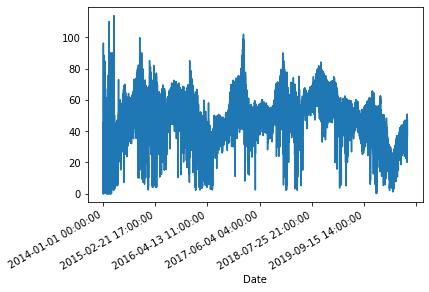

In [ ]:
uni_data.plot(subplots=True)
plt.show()

In [ ]:
uni_data = uni_data.values
uni_data[:5]

array([20.02, 10.34,  5.35,  5.  ,  0.5 ])

It is important to normalize features before training a neural network. A common way to do so is by subtracting the mean and dividing by the standard deviation of each feature.

Note: The mean and standard deviation should only be computed using the training data.

In [ ]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Data normalization

In [ ]:
uni_data_nor = (uni_data-uni_train_mean)/uni_train_std

Expecting that each point is autocorraleted with the previous 30 events, the model will be given the last 20 recorded price observations and needs to learn to predict the price at the next time step. 


In [ ]:
univariate_past_history = 20
univariate_future_target = 0


x_train_uni, y_train_uni = univariate_window(dataset=uni_data_nor, start_index=0, end_index=TRAIN_SPLIT, 
                                           history_size=univariate_past_history, target_size=univariate_future_target)
x_val_uni, y_val_uni = univariate_window(dataset=uni_data_nor, start_index=TRAIN_SPLIT, end_index=None, 
                                       history_size=univariate_past_history, target_size=univariate_future_target)

The functions for plot the predictions are created

In [7]:
def time_steps_creation(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [8]:
def plot_pred(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = time_steps_creation(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

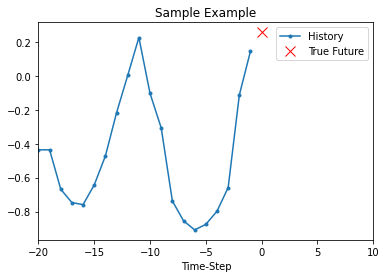

In [ ]:
idx = np.random.randint(0, TRAIN_SPLIT)
plot_pred([x_train_uni[idx], y_train_uni[idx]], 0, 'Sample Example')
plt.show()

### Baseline
Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 30 observations. This simple baseline is known as the Moving Average (MA)

In [9]:
def ma(history):
  return np.mean(history)

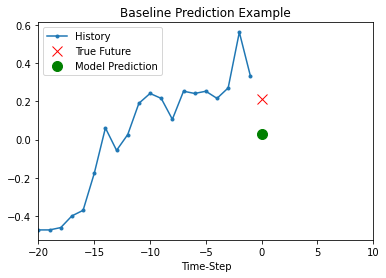

In [ ]:
idx = np.random.randint(0, TRAIN_SPLIT)
plot_pred([x_train_uni[idx], y_train_uni[idx], ma(x_train_uni[idx])], 0, 
          'Baseline Prediction Example')
plt.show()

In order to compare we also create the WMA (Wieghthed Moving Average) a fancier versions of MA

In [10]:
def wma(history):
  history = np.squeeze(history)
  weights = np.arange(history.size)
  history = history.dot(weights)/weights.sum()
  return np.mean(history)

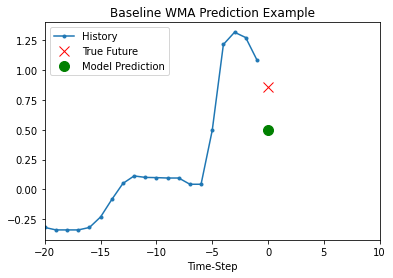

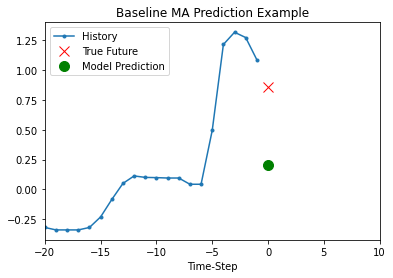

In [ ]:
idx = np.random.randint(0, TRAIN_SPLIT)
plot_pred([x_train_uni[idx], y_train_uni[idx], wma(x_train_uni[idx])], 0, 
          'Baseline WMA Prediction Example')
plt.show()

plot_pred([x_train_uni[idx], y_train_uni[idx], ma(x_train_uni[idx])], 0, 
          'Baseline MA Prediction Example')
plt.show()

### Recurrent neural network


#### Data preparation

In [ ]:
x_train_uni.shape, y_train_uni.shape

((39980, 20, 1), (39980,))

In [13]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

NameError: ignored

#### LSTM model


Epoch 1/30
800/800 [==============================] - 4s 4ms/step - loss: 0.2958 - val_loss: 0.1106
Epoch 2/30
800/800 [==============================] - 3s 4ms/step - loss: 0.1399 - val_loss: 0.1062
Epoch 3/30
800/800 [==============================] - 3s 4ms/step - loss: 0.1351 - val_loss: 0.1044
Epoch 4/30
800/800 [==============================] - 3s 4ms/step - loss: 0.1317 - val_loss: 0.1029
Epoch 5/30
800/800 [==============================] - 3s 4ms/step - loss: 0.1302 - val_loss: 0.1017
Epoch 6/30
800/800 [==============================] - 3s 4ms/step - loss: 0.1291 - val_loss: 0.1002
Epoch 7/30
800/800 [==============================] - 3s 4ms/step - loss: 0.1286 - val_loss: 0.1001
Epoch 8/30
800/800 [==============================] - 3s 4ms/step - loss: 0.1280 - val_loss: 0.0998
Epoch 9/30
800/800 [==============================] - 3s 4ms/step - loss: 0.1276 - val_loss: 0.1005
Epoch 10/30
800/800 [==============================] - 3s 4ms/step - loss: 0.1272 - val_loss: 0.0995

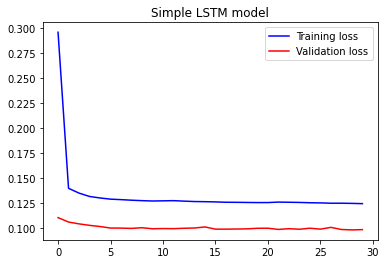

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

EVALUATION_INTERVAL = 800
EPOCHS = 30

h = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)
train_history(h, 'Simple LSTM model')


for x, y in val_univariate.take(3):
  print("Predicitions for one sample")
  print("*"*20)

  xx, yy = x[0].numpy(), y[0].numpy()
  plot = plot_pred([xx, yy, ma(xx)], 0, 
          'Baseline MA Prediction Example')
  plot.show()
  plot = plot_pred([xx, yy, wma(xx)], 0, 
          'Baseline MA Prediction Example')
  plot.show()
  lstm_pred = simple_lstm_model.predict(x)[0]
  plot = plot_pred([xx, yy, lstm_pred], 0, 'Simple LSTM model')
  plot.show()

#### Predict simple LSTM model

Note that the dataset is made up of tensors, rather than actual numy arrays, and thus it has to be evaluated first.


#### Evaluation


In [23]:
def evaluate_baseline(model, x_data, y_data):
  mae = 0.0
  for x, y in zip(x_data, y_data):
    p = model(x)
    mae += abs(y-p)
  return mae/x_data.shape[0]

In [ ]:
mae_b = evaluate_baseline(ma, x_val_uni, y_val_uni)
mae_b2 = evaluate_baseline(wma, x_val_uni, y_val_uni)
mae = simple_lstm_model.evaluate(val_univariate, steps=1000)

print("MAE for basline MA is %.4f" %mae_b)
print("MAE for basline WMA is %.4f" %mae_b2)
print("MAE for LSTM is %.4f" %mae)

1000/1000 [==============================] - 2s 2ms/step - loss: 0.0961
MAE for basline MA is 0.3200
MAE for basline WMA is 0.2884
MAE for LSTM is 0.0961


## Part 2: Multivariate time series

The original dataset contains 5 features those are the ones to be used now. It is essential to include dates as electrical price has clear daily and yearly periodicity.

A simple approach to convert it to a usable signal is to use `sin` and `cos` to convert the time to clear "Time of day" and "Time of year" signals:

In [11]:
date_time = pd.to_datetime(df.pop('Date'), format='%Y-%m-%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [12]:
df.columns

Index(['demand', 'solar', 'wind', 'price', 'Day sin', 'Day cos', 'Year sin',
       'Year cos'],
      dtype='object')

In [13]:
columns = ['demand', 'solar', 'wind', 'price', 'Day sin', 'Day cos', 'Year sin',
       'Year cos']

In [14]:
features = df[columns]
features.head()

,demand,solar,wind,price,Day sin,Day cos,Year sin,Year cos
0,26252.0,3.5,10790.0,20.02,-1.067931e-11,1.000000,0.005677,0.999984
1,24040.0,0.0,10885.0,10.34,2.588190e-01,0.965926,0.006394,0.999980
2,22829.0,0.0,10984.0,5.35,5.000000e-01,0.866025,0.007110,0.999975
3,21816.0,0.5,10680.0,5.00,7.071068e-01,0.707107,0.007827,0.999969
4,21439.0,2.2,10605.0,0.50,8.660254e-01,0.500000,0.008544,0.999963


Features vary across time.

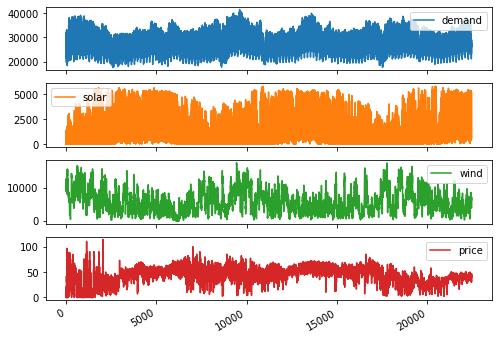

In [19]:
features.plot(subplots=True, figsize=(8,6))
plt.show()

As mentioned, the first step will be to normalize the dataset using the mean and standard deviation of the training data.

In [15]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [16]:
dataset = (dataset-data_mean)/data_std

### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [17]:
def multivariate_window(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

The network is shown data from the last five (5) days, i.e. 120 observations that are sampled every hour and represent history of the last five days.  

For the single step prediction model, the label for a datapoint is the price 12 hours into the future.

In [18]:
past_history = 120
future_target = 12
STEP = 1
SINGLE_STEP = True

x_train_single, y_train_single = multivariate_window(dataset=dataset, target=dataset[:, 3], 
  start_index=0, end_index=TRAIN_SPLIT, history_size=past_history,
  target_size=future_target, step=STEP, single_step=SINGLE_STEP)
x_val_single, y_val_single = multivariate_window(dataset=dataset, target=dataset[:, 3], 
  start_index=TRAIN_SPLIT, end_index=None, history_size=past_history,
  target_size=future_target, step=STEP, single_step=SINGLE_STEP)

In [19]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

Shape of a single data-point.



In [20]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 8)


In [21]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the price, the plot only displays the past price. The prediction is made one day into the future (hence the gap between the history and prediction). 

Epoch 1/20
200/200 [==============================] - 4s 20ms/step - loss: 0.4377 - val_loss: 0.3739
Epoch 2/20
200/200 [==============================] - 3s 16ms/step - loss: 0.3647 - val_loss: 0.3047
Epoch 3/20
200/200 [==============================] - 3s 16ms/step - loss: 0.3399 - val_loss: 0.2905
Epoch 4/20
200/200 [==============================] - 3s 16ms/step - loss: 0.3364 - val_loss: 0.3434
Epoch 5/20
200/200 [==============================] - 3s 17ms/step - loss: 0.3244 - val_loss: 0.3292
Epoch 6/20
200/200 [==============================] - 3s 16ms/step - loss: 0.3061 - val_loss: 0.2963
Epoch 7/20
200/200 [==============================] - 3s 17ms/step - loss: 0.2975 - val_loss: 0.2915
Epoch 8/20
200/200 [==============================] - 3s 16ms/step - loss: 0.3091 - val_loss: 0.3517
Epoch 9/20
200/200 [==============================] - 3s 16ms/step - loss: 0.2906 - val_loss: 0.3122
Epoch 10/20
200/200 [==============================] - 3s 17ms/step - loss: 0.2822 - val_lo

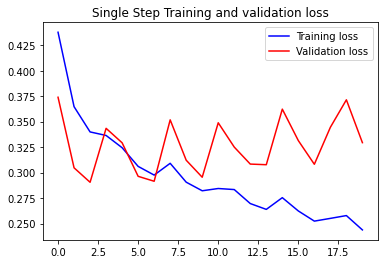

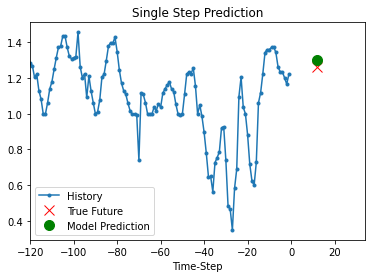

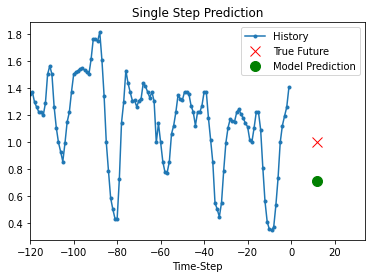

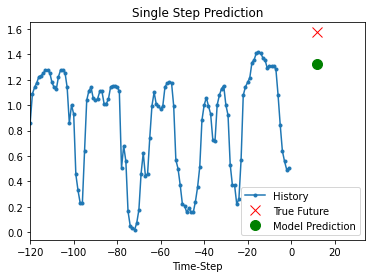

1000/1000 [==============================] - 7s 7ms/step - loss: 0.3382
MAE for basline MA is 0.7923
MAE for basline WMA is 0.8470
MAE for LSTM is 0.3382


In [24]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:],
                                           return_sequences=True))
single_step_model.add(tf.keras.layers.LSTM(32,
                                           return_sequences=False))
single_step_model.add(tf.keras.layers.Dense(16, activation='tanh'))
single_step_model.add(tf.keras.layers.Dense(8, activation='tanh'))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

EPOCHS = 20
EVALUATION_INTERVAL = 200
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

train_history(single_step_history,
                   'Single Step Training and validation loss')
plt.show()

for x, y in val_data_single.take(3):
  plot = plot_pred([x[0][:, 3].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

mae_b = evaluate_baseline(ma, x_val_single[:, 3], y_val_single)
mae_b2 = evaluate_baseline(wma, x_val_single[:, 3], y_val_single)
mae = single_step_model.evaluate(val_data_single, steps=1000)

print("MAE for basline MA is %.4f" %mae_b)
print("MAE for basline WMA is %.4f" %mae_b2)
print("MAE for LSTM is %.4f" %mae)

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='single_step_model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the price for the next 12 hours.For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [52]:
past_history = 360
future_target = 6
STEP = 1
SINGLE_STEP = False

x_train_multi, y_train_multi = multivariate_window(dataset=dataset, target=dataset[:, 3], 
  start_index=0, end_index=TRAIN_SPLIT, history_size=past_history,
  target_size=future_target, step=STEP, single_step=SINGLE_STEP)
x_val_multi, y_val_multi = multivariate_window(dataset=dataset, target=dataset[:, 3], 
  start_index=TRAIN_SPLIT, end_index=None, history_size=past_history,
  target_size=future_target, step=STEP, single_step=SINGLE_STEP)

Let's check out a sample data-point.

In [53]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (360, 8)

 Target temperature to predict : (6,)


In [54]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [38]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = time_steps_creation(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 3]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

#### Predict a multi-step future


Epoch 1/20
200/200 [==============================] - 8s 40ms/step - loss: 0.4570 - val_loss: 0.3447
Epoch 2/20
200/200 [==============================] - 7s 36ms/step - loss: 0.2791 - val_loss: 0.2334
Epoch 3/20
200/200 [==============================] - 7s 36ms/step - loss: 0.2451 - val_loss: 0.2227
Epoch 4/20
200/200 [==============================] - 7s 36ms/step - loss: 0.2382 - val_loss: 0.2732
Epoch 5/20
200/200 [==============================] - 7s 36ms/step - loss: 0.2258 - val_loss: 0.2088
Epoch 6/20
200/200 [==============================] - 7s 37ms/step - loss: 0.2122 - val_loss: 0.2098
Epoch 7/20
200/200 [==============================] - 7s 36ms/step - loss: 0.2072 - val_loss: 0.2412
Epoch 8/20
200/200 [==============================] - 7s 36ms/step - loss: 0.2117 - val_loss: 0.2363
Epoch 9/20
200/200 [==============================] - 7s 37ms/step - loss: 0.1979 - val_loss: 0.2038
Epoch 10/20
200/200 [==============================] - 7s 36ms/step - loss: 0.1944 - val_lo

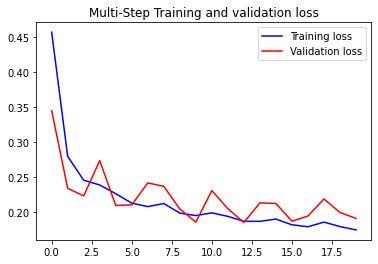

1000/1000 [==============================] - 17s 17ms/step - loss: 0.1902
MAE for LSTM is 0.1902


In [56]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_multi.shape[-2:],
                                           return_sequences=True))
multi_step_model.add(tf.keras.layers.LSTM(32,
                                           return_sequences=False))
multi_step_model.add(tf.keras.layers.Dense(16, activation='tanh'))
multi_step_model.add(tf.keras.layers.Dense(8, activation='tanh'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')


EPOCHS = 20
EVALUATION_INTERVAL = 200



multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50,)

train_history(multi_step_history, 'Multi-Step Training and validation loss')

mae = multi_step_model.evaluate(val_data_multi, steps=1000)

print("MAE for LSTM is %.4f" %mae)

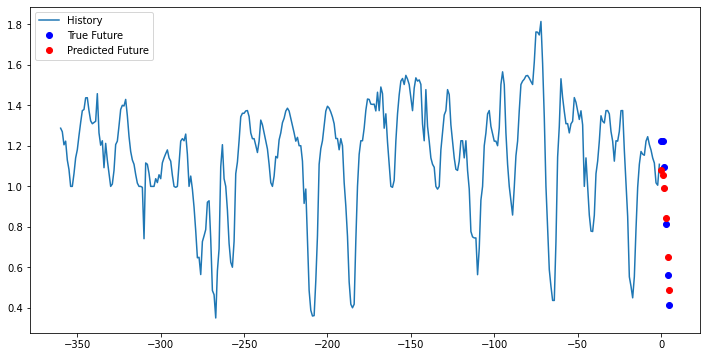

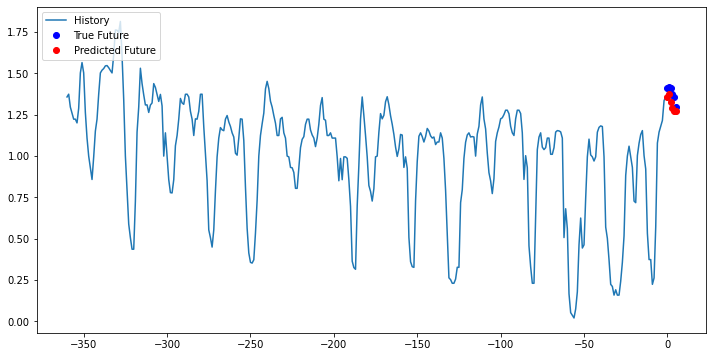

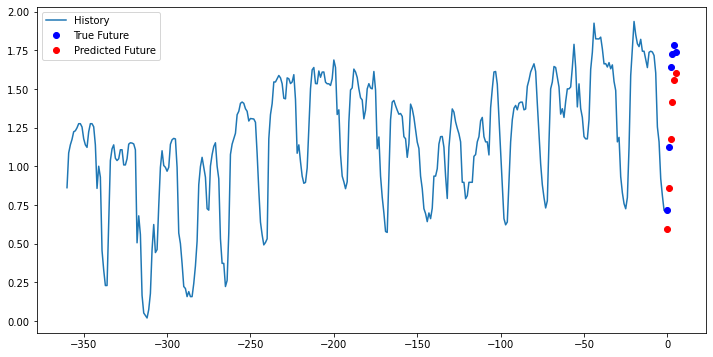

In [58]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [57]:
multi_step_model.save('multi_step_final.h5')